### Install binance package

Create an .env File with your Binance Credentials:
```
 export BINANCE_KEY=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
 export BINANCE_SECRET=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
```

In [1]:
%load_ext dotenv
%dotenv

In [2]:
# IMPORTS
import pandas as pd
import math
import os.path
import os
import time
import numpy as np
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = os.getenv('BINANCE_KEY')    #Enter your own API-key here
binance_api_secret = os.getenv('BINANCE_SECRET')  #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "15m": 15, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df



In [3]:
binance_symbols = ["BTCEUR", "ETHEUR", "ADAEUR"]
for symbol in binance_symbols:
    get_all_binance(symbol,Client.KLINE_INTERVAL_1MINUTE, save = True)
for symbol in binance_symbols:
    get_all_binance(symbol,Client.KLINE_INTERVAL_15MINUTE, save = True)
for symbol in binance_symbols:
    get_all_binance(symbol,Client.KLINE_INTERVAL_1DAY, save = True)

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!


In [4]:
btc=pd.read_csv("BTCEUR-1m-data.csv")
btc.tail()
interval=60*24 # interval is the number of columns per day

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib

<AxesSubplot:xlabel='timestamp'>

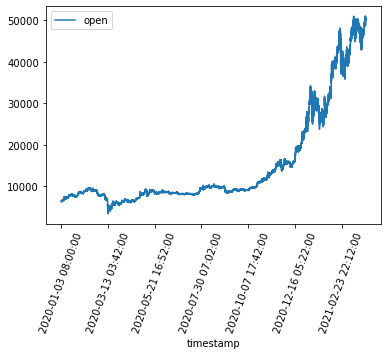

In [6]:
btc.plot(x="timestamp", y="open",rot=70)

In [51]:
#data = btc[(btc['timestamp'] > '2021-03-20 00:00:00') ]
# last 30 days (in 15min chunks)
data = btc[-interval*100:] 
data

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
507556,2020-12-21 11:18:00,18797.49,18800.65,18759.36,18778.87,4.492922,1608549539999,84398.688885,366,3.720173,69883.813979,0
507557,2020-12-21 11:19:00,18778.87,18779.04,18737.04,18749.75,1.596721,1608549599999,29946.103684,346,0.795891,14926.311135,0
507558,2020-12-21 11:20:00,18749.02,18752.44,18687.01,18733.38,5.474144,1608549659999,102493.551189,393,3.281761,61442.683187,0
507559,2020-12-21 11:21:00,18725.85,18738.81,18679.07,18700.82,7.485955,1608549719999,140053.726295,453,4.281895,80128.583761,0
507560,2020-12-21 11:22:00,18700.75,18750.00,18697.64,18706.53,3.398573,1608549779999,63637.475559,369,1.391483,26057.253832,0
...,...,...,...,...,...,...,...,...,...,...,...,...
651551,2021-03-31 18:48:00,50485.70,50530.55,50467.86,50530.55,4.468727,1617216539999,225652.267287,124,2.704087,136565.714070,0
651552,2021-03-31 18:49:00,50530.00,50575.49,50508.90,50550.09,2.914137,1617216599999,147279.399085,115,2.027994,102504.966727,0
651553,2021-03-31 18:50:00,50554.05,50600.00,50527.30,50594.75,1.630157,1617216659999,82447.099612,112,1.421404,71894.786208,0
651554,2021-03-31 18:51:00,50591.67,50593.81,50562.04,50593.81,0.980184,1617216719999,49579.005870,85,0.627452,31738.920797,0


<AxesSubplot:xlabel='timestamp'>

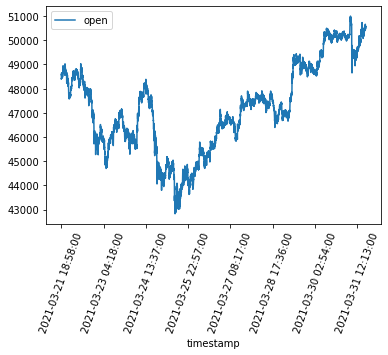

In [8]:
data.plot(x="timestamp", y="open",rot=70)

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

In [52]:
data['datetime'] = pd.to_datetime(data['timestamp'])
data['dates'] = data['datetime'].dt.date
data

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,datetime,dates
507556,2020-12-21 11:18:00,18797.49,18800.65,18759.36,18778.87,4.492922,1608549539999,84398.688885,366,3.720173,69883.813979,0,2020-12-21 11:18:00,2020-12-21
507557,2020-12-21 11:19:00,18778.87,18779.04,18737.04,18749.75,1.596721,1608549599999,29946.103684,346,0.795891,14926.311135,0,2020-12-21 11:19:00,2020-12-21
507558,2020-12-21 11:20:00,18749.02,18752.44,18687.01,18733.38,5.474144,1608549659999,102493.551189,393,3.281761,61442.683187,0,2020-12-21 11:20:00,2020-12-21
507559,2020-12-21 11:21:00,18725.85,18738.81,18679.07,18700.82,7.485955,1608549719999,140053.726295,453,4.281895,80128.583761,0,2020-12-21 11:21:00,2020-12-21
507560,2020-12-21 11:22:00,18700.75,18750.00,18697.64,18706.53,3.398573,1608549779999,63637.475559,369,1.391483,26057.253832,0,2020-12-21 11:22:00,2020-12-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651551,2021-03-31 18:48:00,50485.70,50530.55,50467.86,50530.55,4.468727,1617216539999,225652.267287,124,2.704087,136565.714070,0,2021-03-31 18:48:00,2021-03-31
651552,2021-03-31 18:49:00,50530.00,50575.49,50508.90,50550.09,2.914137,1617216599999,147279.399085,115,2.027994,102504.966727,0,2021-03-31 18:49:00,2021-03-31
651553,2021-03-31 18:50:00,50554.05,50600.00,50527.30,50594.75,1.630157,1617216659999,82447.099612,112,1.421404,71894.786208,0,2021-03-31 18:50:00,2021-03-31
651554,2021-03-31 18:51:00,50591.67,50593.81,50562.04,50593.81,0.980184,1617216719999,49579.005870,85,0.627452,31738.920797,0,2021-03-31 18:51:00,2021-03-31


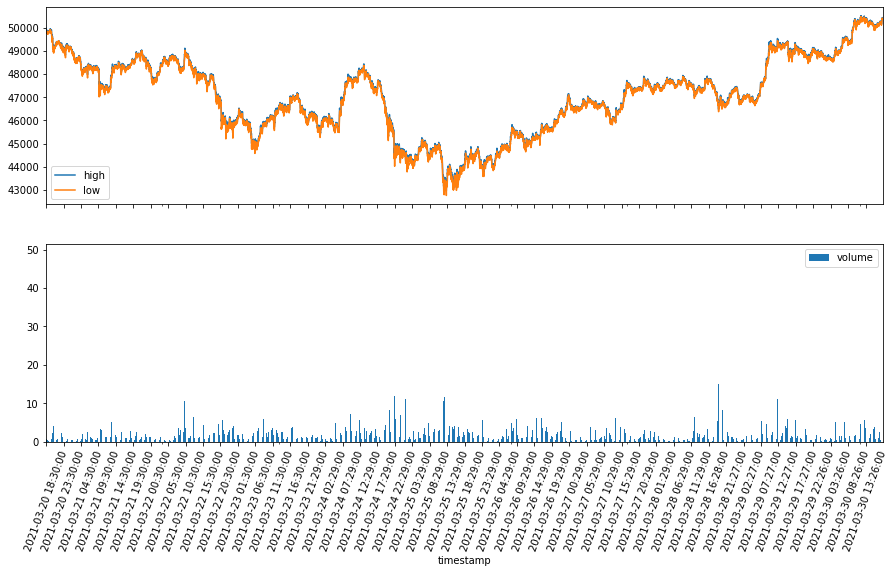

In [11]:

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
data.plot(x="timestamp", y=["high","low"], rot= 70, ax=ax[0])
data.plot.bar(x="timestamp", y="volume", rot= 70, ax=ax[1])
#ax[0].plot(data.timestamp, data.high, rot=70)
#ax[1].bar(data.timestamp, data.volume, width=1/(5*len(data.timestamp)))
#fig.autofmt_xdate()
#ax[1].set_xticklabels(data.dates., rotation=70)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(300))
#ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))

plt.show()

In [53]:
def max_high(values):
    ma = max(values)
    return ma

For each row calculate the max value for the next 24h

In [54]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=interval)
data['maxin24h'] = data['high'].rolling(window=indexer, min_periods=1).apply( max_high)
data

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,datetime,dates,maxin24h
507556,2020-12-21 11:18:00,18797.49,18800.65,18759.36,18778.87,4.492922,1608549539999,84398.688885,366,3.720173,69883.813979,0,2020-12-21 11:18:00,2020-12-21,19397.26
507557,2020-12-21 11:19:00,18778.87,18779.04,18737.04,18749.75,1.596721,1608549599999,29946.103684,346,0.795891,14926.311135,0,2020-12-21 11:19:00,2020-12-21,19397.26
507558,2020-12-21 11:20:00,18749.02,18752.44,18687.01,18733.38,5.474144,1608549659999,102493.551189,393,3.281761,61442.683187,0,2020-12-21 11:20:00,2020-12-21,19397.26
507559,2020-12-21 11:21:00,18725.85,18738.81,18679.07,18700.82,7.485955,1608549719999,140053.726295,453,4.281895,80128.583761,0,2020-12-21 11:21:00,2020-12-21,19397.26
507560,2020-12-21 11:22:00,18700.75,18750.00,18697.64,18706.53,3.398573,1608549779999,63637.475559,369,1.391483,26057.253832,0,2020-12-21 11:22:00,2020-12-21,19397.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651551,2021-03-31 18:48:00,50485.70,50530.55,50467.86,50530.55,4.468727,1617216539999,225652.267287,124,2.704087,136565.714070,0,2021-03-31 18:48:00,2021-03-31,50600.00
651552,2021-03-31 18:49:00,50530.00,50575.49,50508.90,50550.09,2.914137,1617216599999,147279.399085,115,2.027994,102504.966727,0,2021-03-31 18:49:00,2021-03-31,50600.00
651553,2021-03-31 18:50:00,50554.05,50600.00,50527.30,50594.75,1.630157,1617216659999,82447.099612,112,1.421404,71894.786208,0,2021-03-31 18:50:00,2021-03-31,50600.00
651554,2021-03-31 18:51:00,50591.67,50593.81,50562.04,50593.81,0.980184,1617216719999,49579.005870,85,0.627452,31738.920797,0,2021-03-31 18:51:00,2021-03-31,50593.81


### Plot High and maxin24h 

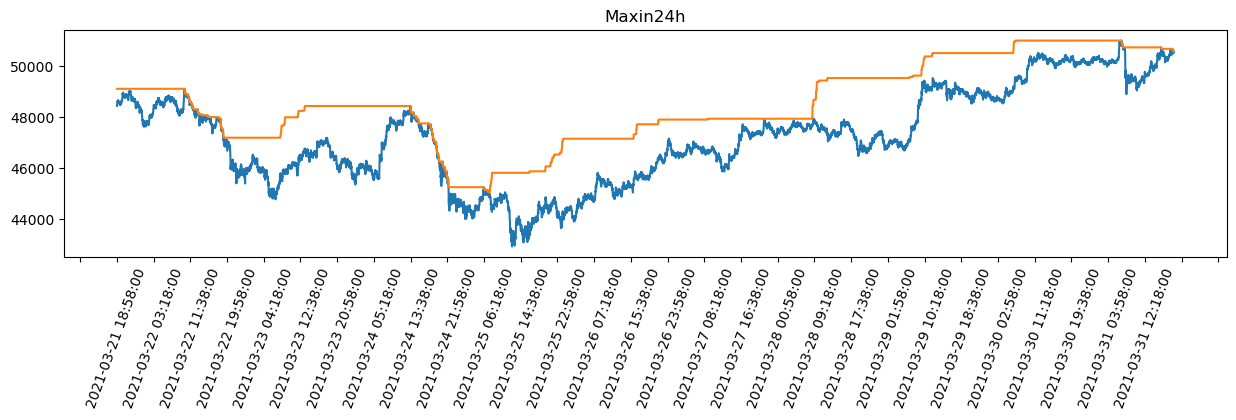

In [13]:
import matplotlib.dates as mdates
plt.close()

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,3), dpi=100)
plt.title('Maxin24h')
ax.plot(data["timestamp"], data["high"])
ax.plot(data["timestamp"], data["maxin24h"])
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
plt.xticks(rotation=70)
plt.show()

now for each row calculate the possible gain if it had to be sold in the next 24h

In [14]:
data['SMA'] = data.iloc[:,3].rolling(window=60*12).mean() # simple moving average
data['CMA'] = data.iloc[:,3].expanding(min_periods=60*12).mean() # cumulative moving average
data['EMA'] = data.iloc[:,3].ewm(span=60*12,adjust=False).mean() # exponential moving average

In [55]:
gain=.02

In [56]:
data['gain']= data['maxin24h']-data['low']
data['good'] = data.apply (lambda row: row['low'] if row['gain']>=row['low']*gain else np.nan, axis=1)
data['bad'] = data.apply (lambda row: row['low'] if row['gain']<row['low']*gain else np.nan, axis=1)

In [57]:
data['buy'] = data.apply (lambda row: row['low'] if row['trades']>1000 else np.nan, axis=1)
colors = np.where(data["good"]>100,'black','purple')

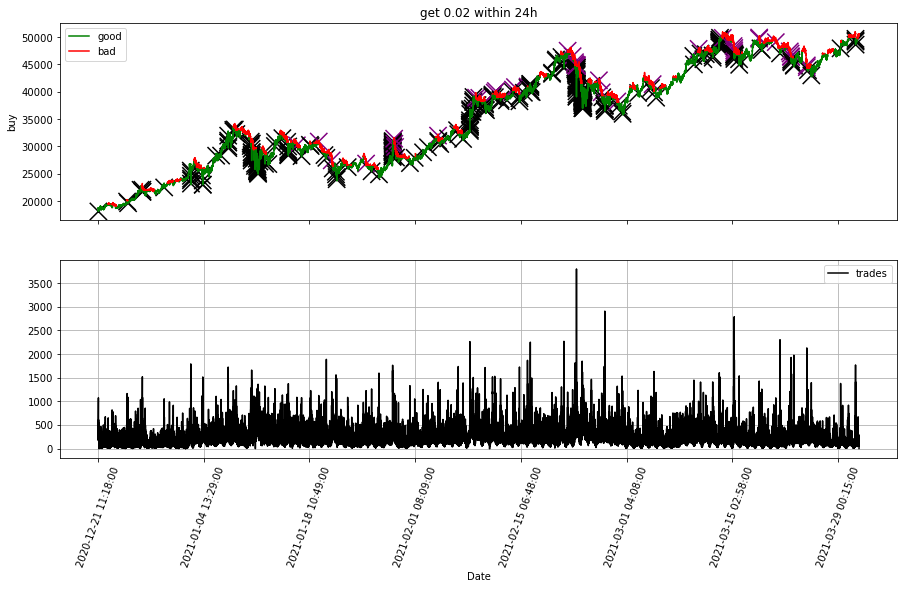

In [58]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
ax[0].set_title(f"get {gain} within 24h")
data.plot(x="timestamp", y='good',  ax=ax[0], color='green',rot= 70)
data.plot(x="timestamp", y='bad',  ax=ax[0], color='red',rot= 70)
#data.plot(x="timestamp", y='CMA',  ax=ax[0], color='blue',rot= 70)
#data.plot(x="timestamp", y='SMA',  ax=ax[0], color='black',rot= 70)
#data.plot(x="timestamp", y='EMA',  ax=ax[0], color='purple',rot= 70)
data.plot(x="timestamp", y='trades',  ax=ax[1], color='black',rot= 70)
data.plot.scatter(x="timestamp", y='buy',  ax=ax[0], color=colors,rot= 70, marker='x', s=300)
plt.xlabel("Date")
plt.grid()
plt.show()

In [50]:
data['good'].count()/data.shape[0]*100

76.16666666666667

In [62]:
g=sum((data['good']>0) & (data['trades']>1000))
b=sum((data['bad']>0) & (data['trades']>1000))
print(f"Good {g} bad {b}  good in % {g/(g+b)*100}")

Good 324 bad 42  good in % 88.52459016393442


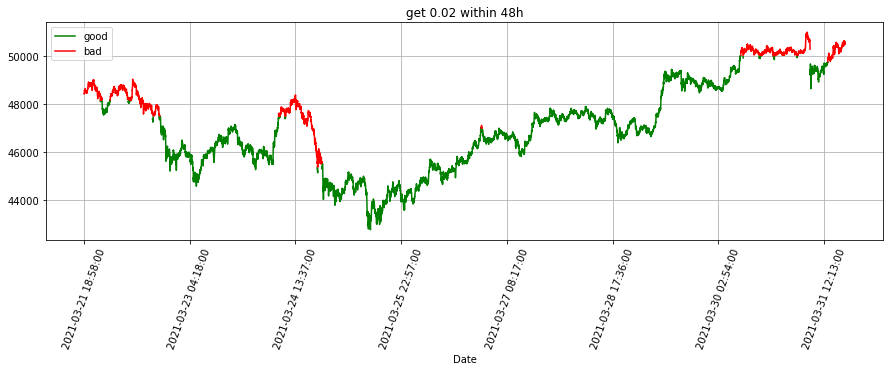

In [19]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=interval*2)
data['maxin24h'] = data['high'].rolling(window=indexer, min_periods=1).apply( max_high)

data['gain']= data['maxin24h']-data['low']
data['good'] = data.apply (lambda row: row['low'] if row['gain']>=row['low']*gain else np.nan, axis=1)
data['bad'] = data.apply (lambda row: row['low'] if row['gain']<row['low']*gain else np.nan, axis=1)

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,4))
data.plot(x="timestamp", y='good',  ax=ax, color='green',rot= 70)
data.plot(x="timestamp", y='bad',  ax=ax, color='red',rot= 70)
plt.title(f"get {gain} within {int(interval*2/60)}h")
plt.xlabel("Date")
plt.grid()
plt.show()

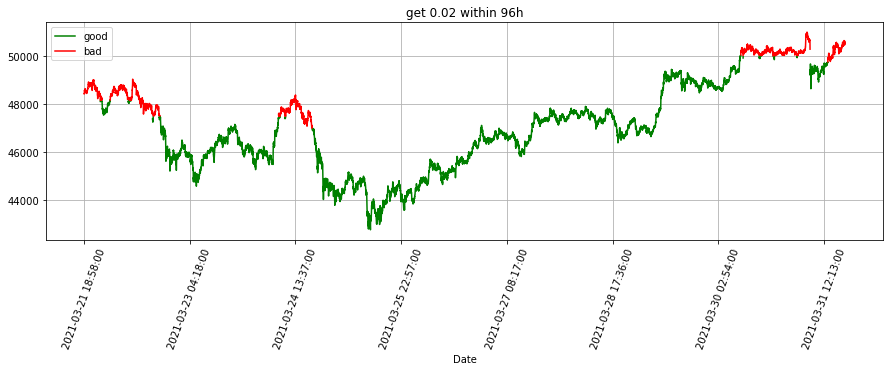

In [20]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=interval*4)
data['maxin24h'] = data['high'].rolling(window=indexer, min_periods=1).apply( max_high)

data['gain']= data['maxin24h']-data['low']
data['good'] = data.apply (lambda row: row['low'] if row['gain']>=row['low']*gain else np.nan, axis=1)
data['bad'] = data.apply (lambda row: row['low'] if row['gain']<row['low']*gain else np.nan, axis=1)

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,4))
data.plot(x="timestamp", y='good',  ax=ax, color='green',rot= 70)
data.plot(x="timestamp", y='bad',  ax=ax, color='red',rot= 70)
plt.title(f"get {gain} within {int(interval*4/60)}h")
plt.xlabel("Date")
plt.grid()
plt.show()

## Try pigeon

In [123]:
!pip install pigeon-jupyter

  Created wheel for pigeon-jupyter: filename=pigeon_jupyter-0.1.0-py3-none-any.whl size=3865 sha256=96e1abf04c9dd8c95f1f253e2cd1a70665a48b7abb1f45e52cfa2f37ced326ec
  Stored in directory: /home/jovyan/.cache/pip/wheels/ee/9e/8c/37506b533a38cb8053b64f928107e521b535d1e37cdbeee265
Successfully built pigeon-jupyter


In [124]:
from pigeon import annotate

sentiment_examples = ['I like this', 'I do not like this', 'This is great']
# The annotations can be retreived from the assigned variable.
annotations = annotate(sentiment_examples, options=["positive", "negative"])

HTML(value='0 examples annotated, 4 examples left')

Output()

Annotation done.


In [125]:
annotations

[('I like this', 'positive'),
 ('I do not like this', 'negative'),
 ('This is great', 'positive')]